# Analyzing R package download frequency

## Download data

In [0]:
!wget http://cran-logs.rstudio.com/2022/2022-08-21.csv.gz

--2022-08-24 13:27:30--  http://cran-logs.rstudio.com/2022/2022-08-21.csv.gz
Resolving cran-logs.rstudio.com (cran-logs.rstudio.com)... 52.218.137.2
Connecting to cran-logs.rstudio.com (cran-logs.rstudio.com)|52.218.137.2|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46338738 (44M) [application/gzip]
Saving to: ‘2022-08-21.csv.gz.2’

2022-08-21.csv.gz.2 100%[===================>]  44.19M  60.9MB/s    in 0.7s    

2022-08-24 13:27:31 (60.9 MB/s) - ‘2022-08-21.csv.gz.2’ saved [46338738/46338738]



## Import data into an Resilient Distributed Dataset (RDD)

In [0]:
# A Spark Context "sc" is already made for us by Databricks.
# Note that we don't have to unzip the data file, `sc.textFile` does that for us.
# `sc.textFile` produces an RDD.

raw_content = sc.textFile("file:///databricks/driver/2022-08-21.csv.gz")
type(raw_content)

Out[2]: pyspark.rdd.RDD

## Data overview

In [0]:
# Let's have a look at a few lines.
raw_content.take(5)

Out[4]: ['"date","time","size","r_version","r_arch","r_os","package","version","country","ip_id"',
 '"2022-08-21","01:03:52",971406,NA,NA,NA,"XML","3.99-0.10","US",1',
 '"2022-08-21","01:03:49",399669,"4.2.1","x86_64","mingw32","remotes","2.4.2","US",2',
 '"2022-08-21","01:03:54",223878,NA,NA,NA,"googlesheets4","1.0.1","US",3',
 '"2022-08-21","01:03:54",64249,"4.2.1","x86_64","linux-gnu","later","1.3.0","US",4']

In [0]:
# How many data lines do we have in total?
raw_content.count()

Out[3]: 3952988

## Intermezzo 1: Set Operations

In [0]:
# Combine two sets, for the case of the same set it results in twice the rows. You can compare that to the `count()` output above.
raw_content.union(raw_content).count()

Out[5]: 7905976

In [0]:
# Show only rows that are the same in both sets. Note that this is less than `raw_content.count()` due to duplicate lines.
raw_content.intersection(raw_content).count()

Out[6]: 3780383

In [0]:
# The above intersection with itself is the same as `distinct()` which shows only unique rows.
raw_content.distinct().count()

Out[7]: 3780383

## Data cleaning

In [0]:
# Turn the string lines from raw_content into an array.
content = raw_content.map(lambda x: x.split(','))

In [0]:
# The lines are split now.
content.take(5)

Out[9]: [['"date"',
  '"time"',
  '"size"',
  '"r_version"',
  '"r_arch"',
  '"r_os"',
  '"package"',
  '"version"',
  '"country"',
  '"ip_id"'],
 ['"2022-08-21"',
  '"01:03:52"',
  '971406',
  'NA',
  'NA',
  'NA',
  '"XML"',
  '"3.99-0.10"',
  '"US"',
  '1'],
 ['"2022-08-21"',
  '"01:03:49"',
  '399669',
  '"4.2.1"',
  '"x86_64"',
  '"mingw32"',
  '"remotes"',
  '"2.4.2"',
  '"US"',
  '2'],
 ['"2022-08-21"',
  '"01:03:54"',
  '223878',
  'NA',
  'NA',
  'NA',
  '"googlesheets4"',
  '"1.0.1"',
  '"US"',
  '3'],
 ['"2022-08-21"',
  '"01:03:54"',
  '64249',
  '"4.2.1"',
  '"x86_64"',
  '"linux-gnu"',
  '"later"',
  '"1.3.0"',
  '"US"',
  '4']]

In [0]:
def clean(line):
    """Remove quotation marks " from data entries."""
    return([item.replace('"', '') for item in line])

content = content.map(clean)

# Now it looks much better.
content.take(5)

## Finding and Counting

In [0]:
# How often was 'ggplot2' downloaded?
ggplot2 = content.filter(lambda x: x[6] == 'ggplot2').count()
ggplot2

Out[12]: 73761

In [0]:
# You can filter for multiple fields at the same time.
ggplot2_nl = content.filter(lambda x: x[6] == 'ggplot2' and x[8] == 'NL').count()
ggplot2_nl

Out[13]: 69

In [0]:
# Let's look at the filtered rows themselves.
ggplot2_nl.take(2)

Out[14]: [['2022-08-21',
  '21:01:22',
  '4123010',
  '4.2.0',
  'x86_64',
  'mingw32',
  'ggplot2',
  '3.3.6',
  'NL',
  '5972'],
 ['2022-08-21',
  '01:34:37',
  '4123010',
  '4.2.1',
  'x86_64',
  'mingw32',
  'ggplot2',
  '3.3.6',
  'NL',
  '7726']]

## Reduce
Filtering works nicely, but let's aggregate and count _all_ packages instead.

In [0]:
# A common way to "reduce" in Spark: Tie a field containing "1" to all lines and sum these fields per key.
package_count = content.map(lambda x: (x[6], 1)).reduceByKey(lambda a,b: a+b)
type(package_count)

Out[15]: pyspark.rdd.PipelinedRDD

In [0]:
# This is how the aggregate looks like now.
package_count.take(5)

Out[16]: [('package', 1),
 ('XML', 5999),
 ('remotes', 7328),
 ('googlesheets4', 12795),
 ('later', 11048)]

In [0]:
# We can still query the count of single packages.
package_count.lookup("XML")

Out[17]: [5999]

# Intermezzo 2: Joins
See https://javarevisited.blogspot.com/2013/05/difference-between-left-and-right-outer-join-sql-mysql.html for details about join flavours.

In [0]:
# Let's split out the country to use as a key.
content_modified=content.map(lambda x:(x[8], x))
content_modified.take(2)

Out[18]: [('country',
  ['date',
   'time',
   'size',
   'r_version',
   'r_arch',
   'r_os',
   'package',
   'version',
   'country',
   'ip_id']),
 ('US',
  ['2022-08-21',
   '01:03:52',
   '971406',
   'NA',
   'NA',
   'NA',
   'XML',
   '3.99-0.10',
   'US',
   '1'])]

In [0]:
# Your mapping list can be as long as you like. As an example, we take two countries. 
mapping=[('NL', 'Netherlands'), ('US', 'United States')]

In [0]:
# Distribute the mapping to form an RDD.
mapping_rdd=sc.parallelize(mapping)

In [0]:
# For comparison with below commands: How many lines does `content_modified` have?
content_modified.count()

Out[36]: 3952988

In [0]:
# Performing an "inner join" operation. This is _shorter_ than `content_modified`, since an "inner join" only produces lines that share a key in both `content_modified` and `mapping_rdd`.
join = content_modified.join(mapping_rdd)
join.count()

Out[37]: 2133909

In [0]:
# This is what the data looks like. Notice that _all_ entries have matched with mapping_rdd and contain the country name as last field.
join.takeSample(withReplacement=False, num=2)

Out[38]: [('US',
  (['2022-08-21',
    '13:10:16',
    '1049664',
    'NA',
    'NA',
    'NA',
    'RecordLinkage',
    '0.4-12.3',
    'US',
    '724'],
   'United States')),
 ('US',
  (['2022-08-21',
    '11:48:10',
    '559',
    'NA',
    'NA',
    'NA',
    'ecotox',
    '1.4.4',
    'US',
    '724'],
   'United States'))]

In [0]:
# Performing a "left outer join" operation. This is exactly as long as `content_modified`, since the key only has to appear in the "left" (`content_modified`) set, and not necessarily in `mapping_rdd`.
left_outer_join = content_modified.leftOuterJoin(mapping_rdd)
left_outer_join.count()

Out[39]: 3952988

In [0]:
# Notice that not all lines have matched with `mapping_rdd`. These lines now contain `None` as last item.
left_outer_join.takeSample(False, 8)

Out[40]: [('US',
  (['2022-08-21',
    '05:19:14',
    '100228',
    'NA',
    'NA',
    'NA',
    'lifecycle',
    '1.0.1',
    'US',
    '6779'],
   'United States')),
 ('US',
  (['2022-08-21',
    '05:09:24',
    '197364',
    'NA',
    'NA',
    'NA',
    'utf8',
    '1.2.2',
    'US',
    '728'],
   'United States')),
 ('US',
  (['2022-08-21',
    '15:37:40',
    '480902',
    'NA',
    'NA',
    'NA',
    'pillar',
    '1.8.1',
    'US',
    '13880'],
   'United States')),
 ('KR',
  (['2022-08-21',
    '10:42:19',
    '76569',
    'NA',
    'NA',
    'NA',
    'pkgload',
    '1.3.0',
    'KR',
    '2108'],
   None)),
 ('US',
  (['2022-08-21',
    '06:42:34',
    '425241',
    'NA',
    'NA',
    'NA',
    'ragg',
    '1.2.2',
    'US',
    '1325'],
   'United States')),
 ('US',
  (['2022-08-21',
    '04:21:47',
    '3766416',
    'NA',
    'NA',
    'NA',
    'corrplot',
    '0.92',
    'US',
    '3'],
   'United States')),
 ('KR',
  (['2022-08-21',
    '06:06:08',
    '271173',


## Sorting

In [0]:
# Let's create a Top 10 list of downloaded R packages.
top_10 = package_count.map(lambda x: (x[1], x[0])).sortByKey(0).take(10)
top_10

Out[25]: [(73761, 'ggplot2'),
 (64695, 'sf'),
 (56201, 'devtools'),
 (55465, 'ragg'),
 (55370, 'textshaping'),
 (50142, 'rgeos'),
 (49376, 'rgl'),
 (42618, 'rlang'),
 (39021, 'pkgdown'),
 (36226, 'cli')]

## Plotting the Top 10
Databricks has nifty visualization options built in. But they are not portable in case you want to run this notebook on a different system.

In [0]:
display(top_10)

_1,_2
73761,ggplot2
64695,sf
56201,devtools
55465,ragg
55370,textshaping
50142,rgeos
49376,rgl
42618,rlang
39021,pkgdown
36226,cli


In [0]:
# We can reproduce the above plot by hand, it's not very difficult.
from matplotlib import pyplot as plt

In [0]:
data = list(zip(*top_10))  # Transpose the list.
data.reverse()  # Switch columns, now they are in the right order for matplotlib.
data

Out[28]: [('ggplot2',
  'sf',
  'devtools',
  'ragg',
  'textshaping',
  'rgeos',
  'rgl',
  'rlang',
  'pkgdown',
  'cli'),
 (73761, 64695, 56201, 55465, 55370, 50142, 49376, 42618, 39021, 36226)]

Out[45]: Text(0, 0.5, 'Downloads per day')

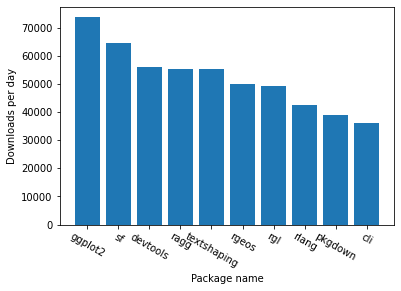

In [0]:
plt.bar(*data)
plt.xticks(rotation=-30)
plt.xlabel("Package name")
plt.ylabel("Downloads per day")

## Bonus

- What are the 10 most downloaded packages last month?
- What are the 10 most downloaded packages last year?

You can find all data here: http://cran-logs.rstudio.com/